#Movie Reviews Sentiment Analysis with Deep Learning

- While we may not directly have the social media (e.g. Twitter or Facebook) comments sentiments, we can use the **products or movies reviews dataset as a proxy**.

- The user comments and the corresponding sentiment ratings are the **labelled dataset** for the **supervised** machine learning

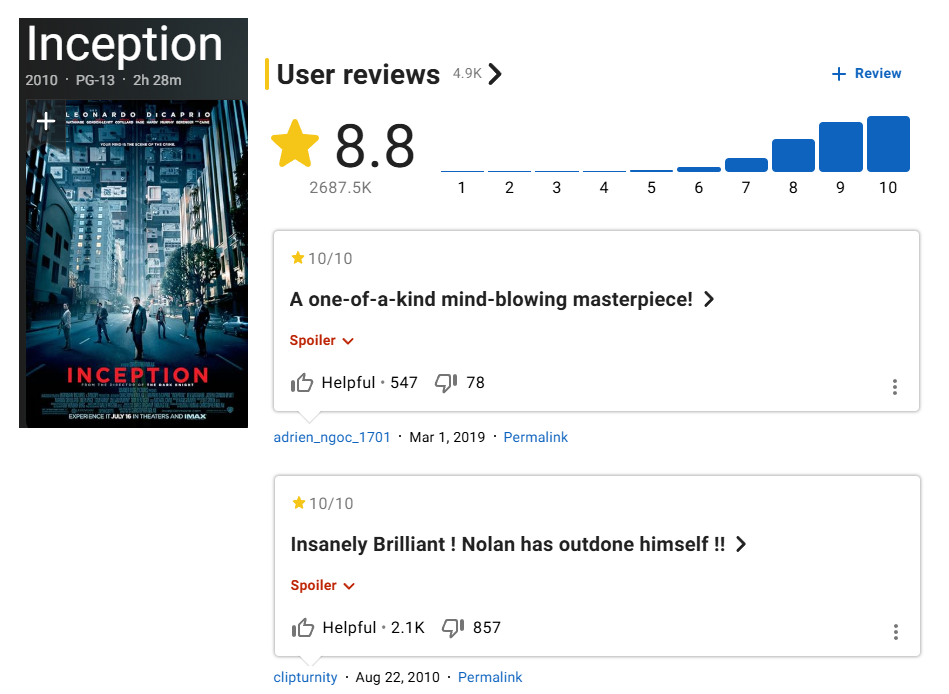

In [ ]:
#@title Execute this block to import Tensorfow deep learning libraries and helper functions
!pip install -q gensim

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.utils import plot_model

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

!wget https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/preprocess.py
import preprocess
from string import punctuation


# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz",
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
      extract=True)

  train_df = load_dataset(os.path.join(dataset, "aclImdb", "train"))

  return train_df


def printInputOutput(index, train, train_text, train_label):
  print("Original input:", train['sentence'][index])
  print("Preprocessed text:", train_text[index])
  print("\nConverted to vector:", sequences[index])
  print("Sentiment label:", train_label[index])
  print("--------------------------")

  # Check the text to number conversion
  currentIndex = 0

  for word in train_text[index].split():
    if word in df_wordIndex.index:
      print(word, "-->", sequences[index][currentIndex])
      currentIndex += 1
    else:
      print(word)

In [ ]:
#@title Step 1: Download the [IMDB movie](https://www.imdb.com/) review **labelled** dataset.
train = download_and_load_datasets()

SHOW = 5
print('Total training rows:', len(train))
train[:SHOW]

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Total training rows: 25000


,sentence,sentiment,polarity
0,The beginning of this movie was good. It start...,1,0
1,"Here I thought ""Nanook of the north"" was the l...",9,1
2,When I think of Return of the Jedi I think epi...,10,1
3,"Red Eye, a movie that id had wanted to see for...",8,1
4,"From the writer of ""What Ever Happened to Baby...",7,1


**Step 2**: Define the input and output

* **Preprocess the reviews** which include remove symbols and stop words, to small cap, stem the words
* **input (the movie reviews)**: the **preprocessed** movie reviews
*   **output (sentiment polarity)**: for simplicity, only use **polarity** (0:Negative, 1:Positive) instead of the sentiment score

In [ ]:
#@title Preprocess the review
train['preprocessed'] = train['sentence'].apply(preprocess.process)

# Define the input and output
train_text = train['preprocessed'].values
train_label = train['polarity'].values

train[:SHOW][['sentence', 'preprocessed', 'polarity']]

,sentence,preprocessed,polarity
0,The beginning of this movie was good. It start...,beginning movie wa good started get really dum...,0
1,"Here I thought ""Nanook of the north"" was the l...",thought nanook north wa last word archaic semi...,1
2,When I think of Return of the Jedi I think epi...,think return jedi think epic yeah ewoks intere...,1
3,"Red Eye, a movie that id had wanted to see for...",red eye movie id wanted see awhile cillian mur...,1
4,"From the writer of ""What Ever Happened to Baby...",writer ever happened baby jane hush hush sweet...,1


In [ ]:
#@title Pick one sample from the dataset to show the input (movie comment) and output (sentiment polarity)

sample = 0 #@param {type:"integer"}

print('input:', train_text[sample])
print('output:', train_label[sample])

input: beginning movie wa good started get really dumb told people wanted kill think came little town like would offended seeing movie made lot people look dumb crazy could people little follow around day lot time people telling way kill like urging many people little respect people also think could made much better ending movie good part movie also people might like recommend anyone
output: 0


**Step 3**: Encoding the data (movie reviews) into Neural Network format

*   Neural Network doesn't understand English word and only take **vector of numbers** for the input
*   Need to represent the input word sequence as vector of numbers for the Neural Network input
*   Use the word **occurency frequency** in the dataset as the word's indexed number (**ranking**) and use it to **encode the words to numbers**
*   The word_frequency is like a dictionary to map words to numbers
*   For simplicity, only consider the **top frequent 10,000 words** in the dataset (less frequent rare words do not have enough information content for training)

In [ ]:
#@title Execute this block to generate the word frequency index

# For simplicity, only consider the top frequent 10,000 words in the dataset (assume more frequent is more important)
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_text)

word_index = tokenizer.word_index
print('Found %s unique tokens but will only consider the top frequent %s words' %(len(word_index), max_words))

# convert the words to a seqence of numbers (index by the top frequency of the words)
# The words in the text sequence will be indexed as a number by the word_index
sequences = tokenizer.texts_to_sequences(train_text)

# show the word_index
df_wordIndex = pd.DataFrame.from_dict(word_index, orient='index', columns=['number'])[:max_words]
df_wordIndex

Found 66440 unique tokens but will only consider the top frequent 10000 words


,number
br,1
movie,2
wa,3
film,4
one,5
...,...
riley,9996
abigail,9997
ana,9998
anal,9999


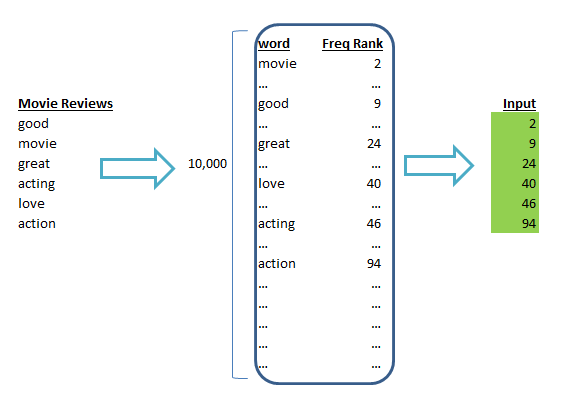

In [ ]:
#@title Pick one sample from the dataset to show the encoded-input and output

sample = 0 #@param {type:"integer"}
printInputOutput(sample, train, train_text, train_label)

Original input: The beginning of this movie was good. It started to get really dumb after he told the people he wanted to kill himself. I think if I came from a little town like that I would be offended after seeing this movie. They made a lot of these people look dumb and crazy. How could these people have so little to do that they follow him around all day. A lot of times these people were telling him ways to kill himself like they were urging him to do it. How can so many people have little respect for other people? I also think they could have made a much better ending for this movie. There were some good parts to this movie also. Some people might like it, but I wouldn't recommend this to anyone.
Preprocessed text: beginning movie wa good started get really dumb told people wanted kill think came little town like would offended seeing movie made lot people look dumb crazy could people little follow around day lot time people telling way kill like urging many people little respect 

In [ ]:
#@title Cut the input (movie reviews) after maxlen words (e.g. 200) because neural network input is fixed size vector

maxlen = 200
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(train_label)

print('Shape of data tensor', data.shape)
print('Shape of labels tensor', labels.shape)

Shape of data tensor (25000, 200)
Shape of labels tensor (25000,)


In [ ]:
#@title Show the Network Network Input (Vector of a fixed size) and Output (Sentiment Polarity)

sample = 0 #@param {type:"integer"}

# Now the training X, Y is the acceptable format by Neural Network
# Input X is a vectors and Y is the corresponding labels (i.e. the sentiment polarity)
print(data[sample])
print("\n lable:", labels[sample])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  343    2
    3    9  521   13   17  828  458   21  362  260   32  276   48  373
    6   14 3732  213    2   28   65   21   44  828  749   31   21   48
  638   99   83   65    8   21  819   26  260    6   42   21   48  908
   21   23   32   31   28   20   53  171    2    9   58    2   23   21
  136 

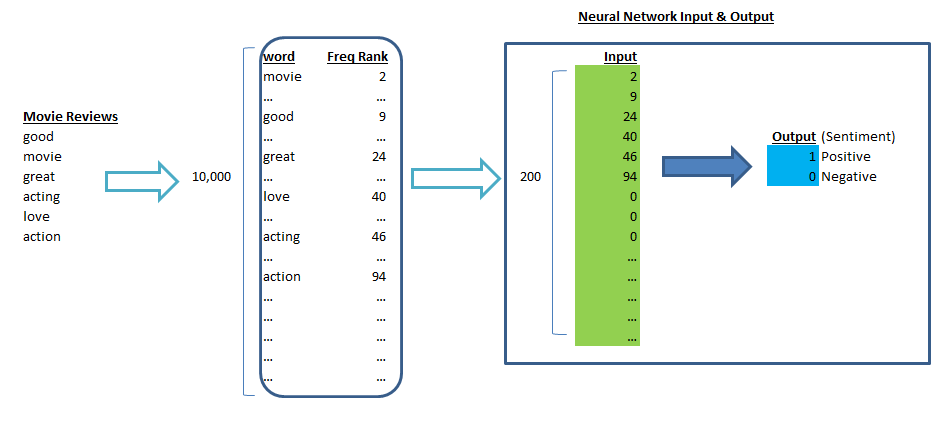

In [ ]:
#@title Split the data into training, validation and test set

training_samples = 16000
validation_samples = 4000
test_samples = 5000

# Split the data into a training set and a validation set
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]

test_text = train_text[training_samples + validation_samples:]
test_label = train_label[training_samples + validation_samples:]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (16000, 200)
y_train shape: (16000,)
x_val shape: (4000, 200)
y_val shape: (4000,)
x_test shape: (5000, 200)
y_test shape: (5000,)


**Step 4**: Use the one hidden Dense layer connection which is similar to the MNIST (Digit) recognition

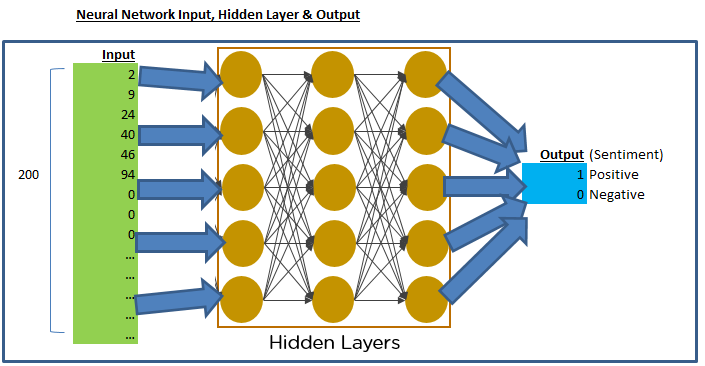

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,465 (25.25 KB)

 Trainable params: 6,465 (25.25 KB)

 Non-trainable params: 0 (0.00 B)

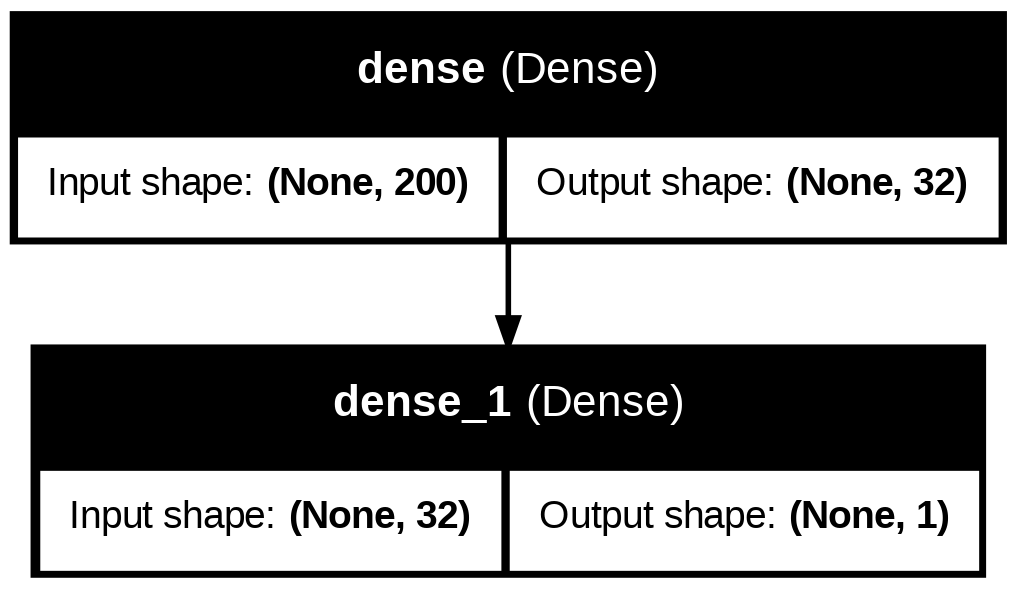

In [ ]:
#@title Build a Dense Neural Network with input output and hidden layers

model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(maxlen,)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)

# [9,2,...,200] --dense--> [1,2,.....,32] --dense_output--> 0 or 1

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5087 - loss: 193.6220 - val_accuracy: 0.5040 - val_loss: 1.7649
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5046 - loss: 1.2281 - val_accuracy: 0.5065 - val_loss: 0.9168
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5065 - loss: 0.8572 - val_accuracy: 0.5077 - val_loss: 0.8463
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5053 - loss: 0.7324 - val_accuracy: 0.5063 - val_loss: 0.8101
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4999 - loss: 0.7266 - val_accuracy: 0.5077 - val_loss: 0.7911
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5043 - loss: 0.7112 - val_accuracy: 0.5090 - val_loss: 0.8035
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4987 - loss: 0.7050 - val_accuracy: 0.5085 - val_loss: 0.8143
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5128 - loss: 0.7059 - val_accuracy: 

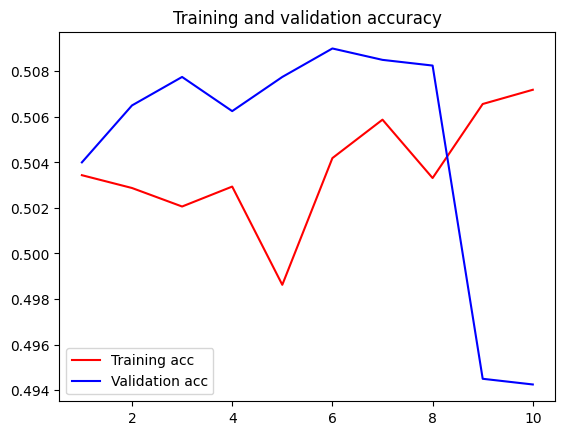

In [ ]:
#@title Train the Neural Network with the input number of epochs

epochs = 10 #@param {type:"integer"}

history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

The accuracy is not high. As **human langauge is complex** and the input contain 200 numbers, try with more neurons and layers?

*   As usual, the neural network will **learn the input/output associations** (i.e. map the sentence in sequence numberrs to the corresponding sentiment label)

*   However, in order to learning the associations (mapping) effectively, neural network needs to understand the text (which are now merely encoded as numbers by the frequency of appearance in the movies reviews)

*   So the challenge is that the Neural Network has to learn 2 things (**input/output mapping and language understanding**) at the same time

*   Comparing to the image recognition, the pixel positions are naturally mapped to the vectors to represent the **image spatial relationship**.


# Word2Vec
- The key idea here is to use word2vec (a pretrained vector which understand the text to certain extends) to solve the 2nd issue (text understanding) and helps the neural network to learn the input/output mappings.

- The word2vec output is a vector and which is exactly the required format for Neural Network

In [ ]:
#@title Import gensim library and run the word2vec model with the following parameters

import ipywidgets as widgets
from IPython.display import display

from gensim.models import word2vec
min_count = 5 #@param {type:"integer"}
dimension = 32 #@param {type:"integer"}
window_size = 5 #@param {type:"integer"}

reviews = [sent.split(' ') for sent in train['preprocessed']]
w2vModel = word2vec.Word2Vec(reviews, min_count=min_count, vector_size=dimension, window=window_size)
w2v = w2vModel.wv

print("No.of words in the vocab:", len(w2v.index_to_key))

wordCombo = widgets.Combobox(
    placeholder='Choose a word',
    options=w2v.index_to_key,
    description='Words:',
    ensure_option=True,
    disabled=False
)

display(wordCombo)


No.of words in the vocab: 25582


Combobox(value='', description='Words:', ensure_option=True, options=('br', 'movie', 'wa', 'film', 'one', 'lik…

In [ ]:
w2v.most_similar(wordCombo.value)

[('actress', 0.8415179252624512),
 ('performer', 0.8334487676620483),
 ('casting', 0.7839877605438232),
 ('cast', 0.7354490756988525),
 ('talent', 0.7230303287506104),
 ('talented', 0.7146039009094238),
 ('choice', 0.7057070732116699),
 ('professional', 0.6930217742919922),
 ('supporting', 0.6847969889640808),
 ('chemistry', 0.6830877065658569)]

In [ ]:
# word in w2v is represented by a vector of numbers
w2v[wordCombo.value]

array([ 1.5319973 ,  0.5615325 , -0.9429269 , -0.4939931 ,  4.4241405 ,
       -0.4731945 ,  0.10590053,  3.2741804 ,  1.2572982 , -2.8758583 ,
       -1.1811904 , -4.69951   ,  0.753639  ,  1.0322034 , -0.18938956,
       -0.08682394,  3.4835472 ,  4.8144217 , -1.607175  , -0.59601176,
       -1.5526102 ,  1.639089  ,  0.2398014 ,  1.7445475 ,  0.36105525,
       -0.47753388,  0.13651682, -1.2752856 , -0.20346339,  0.42070976,
       -2.7234643 , -0.35322216], dtype=float32)

* Build the **embedding matrix** from the word2vec that we will be able to add to the Neural Network as a layer called **Embedding layer** each
* For each row, it contains the corresponding word2vec vector to the word freqency index which built during earlier tokenization step.
* Think of the Embedding layer as another dictionary to map each number (the word indexed by the word frequency) to a vector (word2vec)


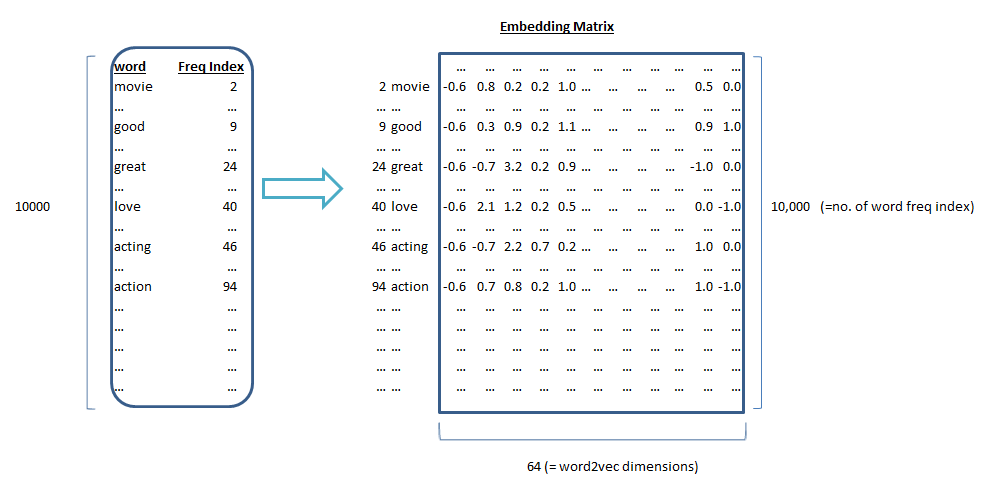

In [ ]:
#@title Prepare the word2vec embedding layer

# Note that the index 0 is not supposed to stand for any word or token -- it's a placeholder.
# The Embedding layer a matrix of shape (max_words, embedding_dim),

embedding_dim = w2v.vector_size
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  # Words not found in embedding index will be all-zeros.
  if word in w2v.key_to_index and i < max_words:
    embedding_matrix[i] = w2v[word]

print("embedding_matrix.shape:", embedding_matrix.shape)

embedding_matrix.shape: (10000, 32)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (10000, 32, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,000 (1.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 320,000 (1.22 MB)

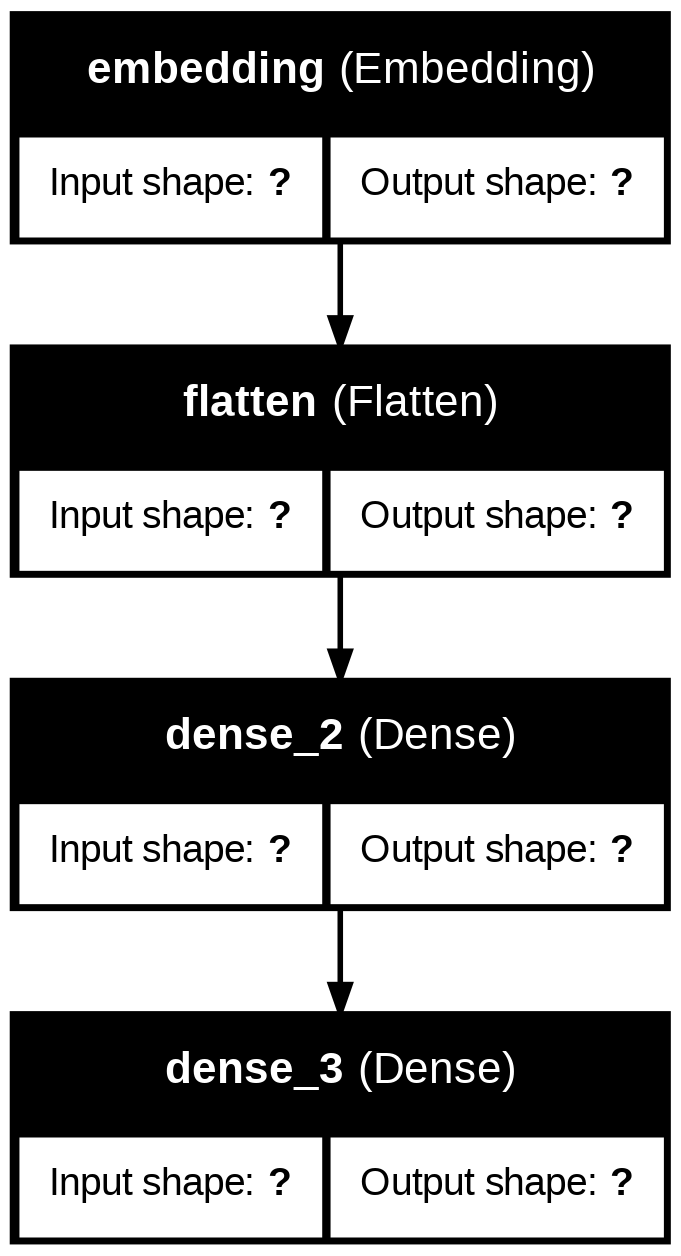

In [ ]:
#@title Embedd the word2vec layer into the above Dense Neural Network
w2vModel = Sequential()

# Use w2v embedding layer to injects "pre-trained" language knowledge
# to encode (represent) the input data more meaningfully
# It is a type of transfer learning
w2vModel.add(Embedding(max_words, embedding_dim, input_length=maxlen))

# Then flatten the embedding output to a single vector for the hidden Dense layer
# flatten the 200 sequence of 300-dim w2v vector into one single vector for dense layer
w2vModel.add(Flatten())
w2vModel.add(Dense(32, activation='relu'))
w2vModel.add(Dense(1, activation='sigmoid'))

# Load the Embedding layer from the embedding_matrix and no need to train the parameters
w2vModel.layers[0].build(embedding_matrix.shape)
w2vModel.layers[0].set_weights([embedding_matrix])
w2vModel.layers[0].trainable = False

w2vModel.summary()

# Embedding layer = max_words * embedding_dim = 10,000 * 300 = 3,000,000
# Flatten = (input) maxlen * embedding_dim = 200 * 300 = 60,000
# dense = flatten_output * dense_output_neurons + bias = 60,000 * 32 + 32 = 1,920,032
# dense_1 = dense_output * dense_1_output + bias = 32 * 1 + 1 = 33

w2vModel.build()
plot_model(w2vModel, show_shapes=True, show_layer_names=True)

# [9,2,...,200] --w2v_embedding--> [[1,3,...,4], [7,5,...19],...] --flatten--> [1,3,...4,7,5,...19,...] --dense--> [1,2,.....,32] --dense_output--> 0 or 1

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7309 - loss: 0.5579 - val_accuracy: 0.7933 - val_loss: 0.4357
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8789 - loss: 0.2875 - val_accuracy: 0.7855 - val_loss: 0.4862
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9391 - loss: 0.1601 - val_accuracy: 0.7887 - val_loss: 0.6077
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9757 - loss: 0.0737 - val_accuracy: 0.7870 - val_loss: 0.8239
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9912 - loss: 0.0304 - val_accuracy: 0.7770 - val_loss: 1.0009
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9965 - loss: 0.0130 - val_accuracy: 0.7830 - val_loss: 1.1663
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0071 - val_accuracy: 0.7765 - val_loss: 1.4131
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.

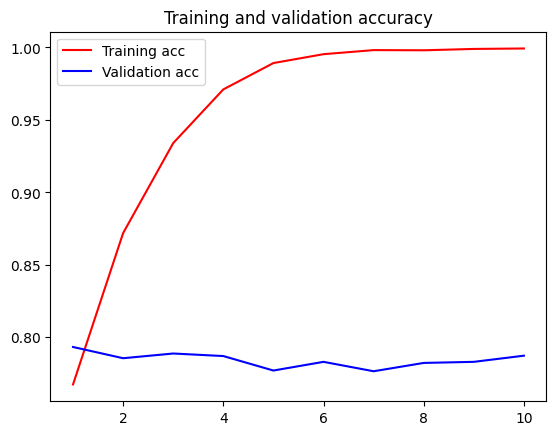

Test loss: 1.7895121574401855
Test accuracy: 0.7839999794960022
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
#@title Train the Neural Network with the input number of epochs

epochs = 10 #@param {type:"integer"}

# compile the model after setting the Embedding layer to non-trainable
w2vModel.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = w2vModel.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Do the prediction on the test set
score = w2vModel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ans = w2vModel.predict(x_test)

## Try comparing to the dense connection with more neurons

In [ ]:
#@title Pick one sample from the testing data to verify the prediction

test_sample = 0 #@param {type:"integer"}

print("Movie Review:", test_text[test_sample])
print("Truth Sentiment:", test_label[test_sample])
print("Predicted Sentiment:", round(ans[test_sample][0]))

Movie Review: amen magsel wa lot confusion going first know movie purchasing henry cele star every one bought movie thinking wa miniseries letdown would comedy young girl raped david hasselhoff spelling ok popcorn tv wa believable film wa english accent love story movie wa supposed young man rise military power slave ship captain getting jiggly english maiden looking daddy br br paid movie would call police would crime
Truth Sentiment: 0
Predicted Sentiment: 0


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (10000, 32, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,000 (1.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 320,000 (1.22 MB)

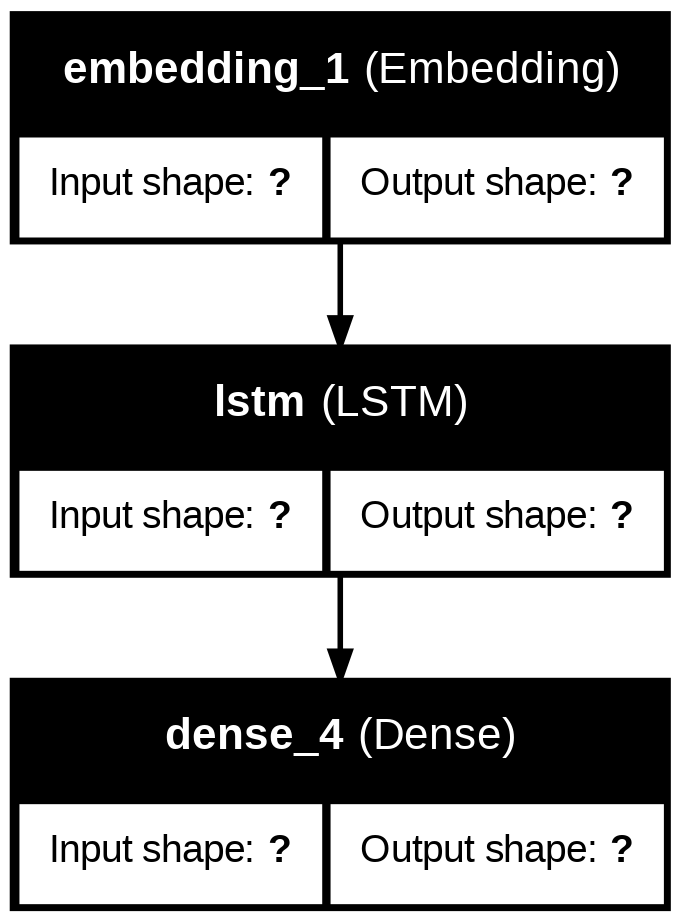

In [ ]:
#@title Change the neural network architecture from dense layer to LSTM which is better for sequence

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
from tensorflow.keras.layers import LSTM

lstm = Sequential()
lstm.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# No need to flatten the vector (required for dense layer but not for LSTM)
lstm.add(LSTM(32))
lstm.add(Dense(1, activation='sigmoid'))

# Load the Embedding layer from the embedding_matrix and no need to train the parameters
lstm.layers[0].build(embedding_matrix.shape)
lstm.layers[0].set_weights([embedding_matrix])
lstm.layers[0].trainable = False

lstm.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

lstm.build()
lstm.summary()
# The lstm (LSTM) Param # = g * [h(h+i) + h]
# where g is number of gates and LSTM = 4
# h = no. of LSTM hidden neurons
# i = the dimension of input (feature)
# 4 * (32 (32 + 300) + 32) = 42624

plot_model(lstm, show_shapes=True, show_layer_names=True)

# [good movie ....] --word_indexed_input--> [9,2,..,200] --w2v_embedding--> [[1,3,...,4], [7,5,...19],...]
#   --LSTM--> [[1,3,...,4], [7,5,...19],...] --dense_output--> 0 or 1

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7170 - loss: 0.5390 - val_accuracy: 0.8242 - val_loss: 0.4053
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8291 - loss: 0.3958 - val_accuracy: 0.8260 - val_loss: 0.3888
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8465 - loss: 0.3683 - val_accuracy: 0.8428 - val_loss: 0.3519
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8619 - loss: 0.3319 - val_accuracy: 0.8520 - val_loss: 0.3377
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8649 - loss: 0.3247 - val_accuracy: 0.8590 - val_loss: 0.3253
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8687 - loss: 0.3072 - val_accuracy: 0.8585 - val_loss: 0.3257
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8779 - loss: 0.2930 - val_accuracy: 0.8637 - val_loss: 0.3196
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8815 - loss: 0.2854 - val_accura

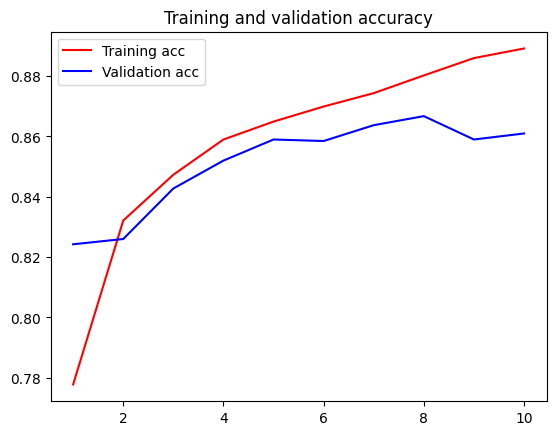

In [ ]:
#@title Train the LSTM Neural Network with the input number of epochs

epochs = 10 #@param {type:"integer"}

batch_size = 128

history = lstm.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

#Takeway


*   Human language is a **sequence of words**. So the **recurrent neural network** (e.g. LSTM) works better than the Dense network
*   When building sentiment analysis engine, the **paradigm shifts** from needing a Linguistic experts and Computer engineerings to **labelled dataset with neural network solutions**



# Suggested changes
 - Better **text preprocessing** (e.g. remove 'br')
 - Try with different **max_words** and **maxlen** in the data processing
 - Try with different training parameters for the word2vec (min_count, size, **window**) - usually train **social media messages with smaller window size** than the formal documents
 - When padding the text sequence to fixed size vector, **removing some portion from the middle** - because usually the first and last sentence are more important as far as sentiment is concerned
 - Tune the neural network **hyper-parameters**
 - Train with other dataset such news sentiment dataset